In [698]:
from torchvision.datasets import QMNIST
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
from einops import rearrange

# Download data
**Pay attention, the following cell will download data in the specified `download_dir` directory.**

We create two datasets. The train set will be used for training our network and the test one for evaluating its performances on unseen data.

In [699]:
download_dir = "./data"

training_data = QMNIST(
        root=download_dir,
        train=True,
        download=True,
        transform=ToTensor()
    )

test_data = QMNIST(
        root=download_dir,
        train=False,
        download=True,
        transform=ToTensor()
    )

# Visualize data and formulate task

A good first habit is to analyze the data we have access to. In our case, we have labeled hand-written numbers from 0 to 9 delivered as 28x28 images with a single channel (grayscale images opposed to 3 channels for RGB images). Pixel values range from 0 to 1 with 0 representing a full black pixel and 1 a full white.

We will treat pixel values as probability of being white. Our toy problem will be an inpainting task. Given half of the image and the class of the digit, fill-in the other half of the image to complete the digit.

Formally, we will model
$$C_{even} = p_{\theta}(C_{even} \mid l, C_{odd})$$
with $C_x$ denoting the cell values in the $x$ columns of the image, $l$ the label of the digit, and $p_{\theta}$ the distribution modelled by our network with learnable parameters $\theta$. 

For this task, we have to adapt our dataset to create task-related input-output pairs. We will do that by implementing a custom pytorch `Dataset` which extracts odd and even columns.

LENGTH OF TRAINING DATASET: 60000
LENGTH OF TEST DATASET: 60000
NUMBER OF ELEMENTS PER SAMPLE: 2
SHAPE OF ELEMENT 0 is torch.Size([1, 28, 28])
SHAPE OF ELEMENT 1 is torch.Size([])


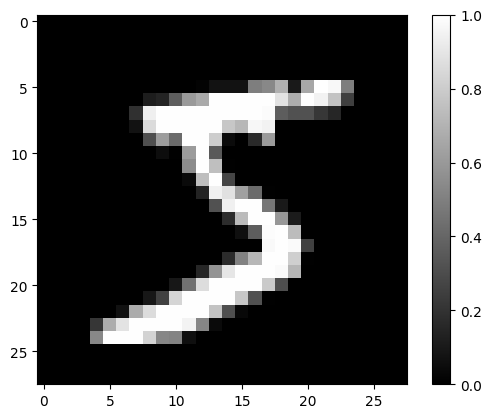

LABEL: 5


In [700]:
print("LENGTH OF TRAINING DATASET:", len(training_data))
print("LENGTH OF TEST DATASET:", len(test_data))

print("NUMBER OF ELEMENTS PER SAMPLE:", len(training_data[0]))

for i, d in enumerate(training_data[0]):
    d = torch.as_tensor(d)
    print(f"SHAPE OF ELEMENT {i} is", d.shape)

# We deduce that the first element is the image with C=1 channels, and H,W = 28 for the width/height

data = training_data[0]
plt.imshow(data[0].squeeze(), cmap="grey")
plt.colorbar()
plt.show()
print("LABEL:", data[1])

In [701]:
class maskedQMNIST(Dataset):
    def __init__(self, qmnist_data):
        super().__init__()

        self.qmnist = qmnist_data
    
    def __len__(self):
        return len(self.qmnist)
    
    def __getitem__(self, index):
        data = self.qmnist[index]
        label = data[1]

        im = data[0].squeeze()
        W = im.shape[-1]
        left_im = im[:, :W//2]
        right_im = im[:, W//2:]

        return left_im, right_im, label

In [702]:
train_set = maskedQMNIST(training_data)
test_set = maskedQMNIST(test_data)

In [703]:
# UTILS FOR RECOMBINING TWO HALF

def recompose_image(left, right):
    composed = torch.cat([left, right], dim=-1)

    return composed

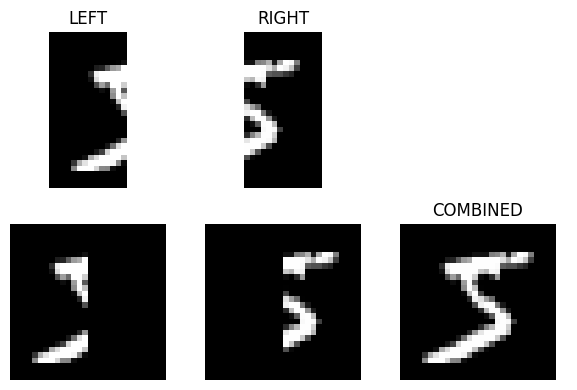

LABEL: 5


In [704]:
# Visualize data from our custom dataset

# Empty image:
left, right, lab = train_set[0]
empty_half = torch.zeros_like(right)

f, a = plt.subplots(2, 3, figsize=(6, 4))
a[0, 0].imshow(left, cmap="grey")
a[0, 0].set_title("LEFT")

a[0, 1].imshow(right, cmap="grey")
a[0, 1].set_title("RIGHT")

a[1, 0].imshow(recompose_image(left, empty_half), cmap="grey")
a[1, 1].imshow(recompose_image(empty_half, right), cmap="grey")

a[1, 2].imshow(recompose_image(left, right), cmap="grey")
a[1, 2].set_title("COMBINED")

for l in a:
    for c in l:
        c.axis("off")

plt.tight_layout()
plt.show()

print("LABEL:", lab)

# Network architecture

In this section, we define our neural network for the prediction task. It will process batch of images so we will receive as input tensors of size `B x H x W` with `B` the batch dimension, choosen by the user. A batch allow the network to process several sample in a single pass. Those element will processed independently by the network which means that we will also output a batch of predictions which are independend along this dimension.

What we have to consider:
- We will implement a simple MLP for this example. As such achitecture process only flat tensors of data, we will have to flatten our input image first. However, to still output images and use them afterward for visualization, we will unflatten our data once processed by the network.
- We also have to condition on the label. The latter is a single integer ranging from 0 to 9. We will use the native `Embedding` module from pytorch which learns a tensor representation of discrete integer tokens. This way, we will be able to feed a learned representation of our label to the network.
- We will define the learning loss inside the network. This method will be useful during training and will return the classification loss over even column pixels.

Tips: You will see a lot of references to modules from pytorch (`nn.Linear`, `nn.Embedding`, `nn.SiLU`, ...). Do not hesitate to consult the API documentation of pytorch for further details. You will find a lot of detailed explanations and other types of layers, activation functions, losses, ... that you may want to play with in this example or in the imitation learning project.

In [705]:
class MLP(nn.Module):
    def __init__(self, H, W, label_features, hidden_dims, activation=nn.ReLU()):
        super().__init__()

        # create input layer
        self.mlp = [nn.Linear(H * W + label_features, hidden_dims[0]), activation]
        # create all hidden layers
        for i in range(len(hidden_dims) - 1):
            self.mlp += [nn.Linear(hidden_dims[i], hidden_dims[i+1]), activation]

        # create output layer 
        # we use a sigmoid at the output to ensure that the predicted values range between 0 and 1 as they should represent probabilities
        head = [nn.Linear(hidden_dims[-1], H * W), nn.Sigmoid()]

        # we pack the list of all the layers and activation in a sequential network. Layers will be evaluated following the order in the list
        self.mlp = nn.Sequential(*(self.mlp + head))

        self.embed_label = nn.Embedding(10, label_features)

        # we use a binary cross-entropy loss as it is a classification problem between black and white pixels
        self.criterion = nn.BCELoss()

    def forward(self, left_image, label):
        # odd_image is a tensor of shape (B, H, W)
        # label is a tensor of shape (B,)

        _, H, W = left_image.shape

        # embed labels
        label = self.embed_label(label) # now of shape (B, F), with F the label features

        # we flatten the image to be compatible in shape with linear layers
        input_mlp = rearrange(left_image, "B H W -> B (H W)") # now of shape (B, C) with C = H * W

        # we concatenate along the last dimension the label embedding and the flattened image
        input_mlp = torch.cat([input_mlp, label], dim=-1) # now of shape (B, K) with K = C + F, compatible with mlp input size
        
        even_pred = self.mlp(input_mlp)

        # unflatten the output to match the half image shape
        return rearrange(even_pred, "B (H W) -> B H W", H=H, W=W)
    
    def loss(self, left_image, right_image, label):
        pred_left = self.forward(left_image, label)

        return self.criterion(pred_left, right_image)


# Training loop

To train a neural network, we have to 
- setup an optimizer. In this example, we will use the Adam optimizer. The latter will define how the parameters are updated to minimize the loss.
- setup a dataloader that will iterate over our dataset and automatically create batch of data
- setup all our training hyperparameters (number of epochs, batch size, size of the network, ...)

In [706]:
batch_size = 256 # How many samples to pass in parallel to the network during training. 
# The higher, the lower the number of optimization steps in one epoch but the closer the gradient will be to a full gradient descent.
# A small batch size will results in more noisy gradient descent and so will be the loss along one epoch. 

epochs = 32 # Number of full path on the whole dataset
show_every = 8

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True) 
# The shuffle argument allow to have varying batch at every cycling on the dataloader.
# The network will not receive the same sequence of batches from one epoch to the other

loader_test = DataLoader(test_set, batch_size=batch_size) # Ne need to shuffle

# Dimension of half-images
H = 28
W = 14

# Number of features to embed the label
features = 32

# List of number of hidden units at every layer
hiddens = [512, 512]

model = MLP(H, W, features, hiddens)

# Visualize the model
print(model)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=424, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=392, bias=True)
    (5): Sigmoid()
  )
  (embed_label): Embedding(10, 32)
  (criterion): BCELoss()
)


In [707]:
# Keep track of the loss at every steps to display it
losses = []

# The parameters of the model are linked to the optimizer. This allows the optimizer to keep track of parameters that should be updated during training.
# The learning rate, denoted "lr" is a crucial hyperparameter. It will multiply the gradient step made by the optimizer.
# Too high learning rate will result in unstable training.
# Too low learning rate can result in very slow training or being trapped in local optimum.
optim = Adam(model.parameters(), lr=1e-3)

  0%|          | 0/32 [00:02<?, ?it/s, Loss=0.18365579843521118]

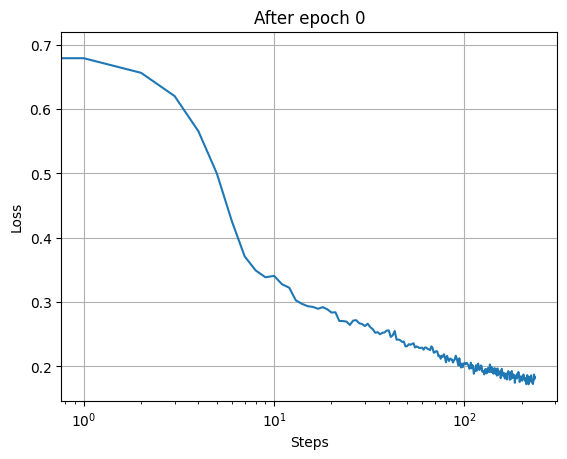

 25%|██▌       | 8/32 [00:21<00:56,  2.35s/it, Loss=0.14934654533863068]

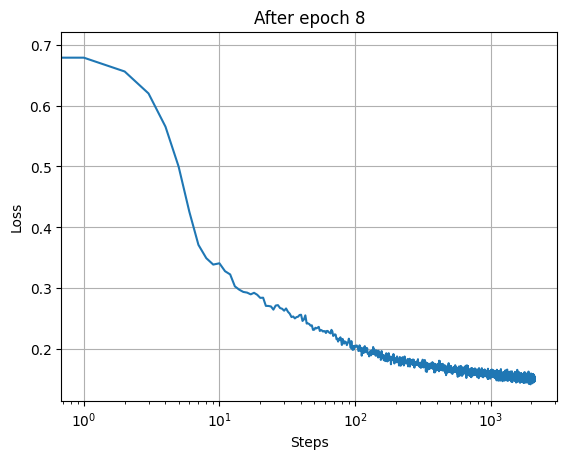

 50%|█████     | 16/32 [00:40<00:37,  2.37s/it, Loss=0.13939103484153748]

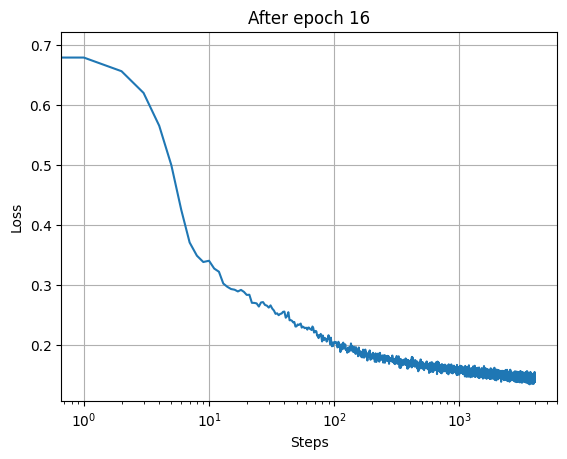

 75%|███████▌  | 24/32 [00:59<00:18,  2.37s/it, Loss=0.14441582560539246]

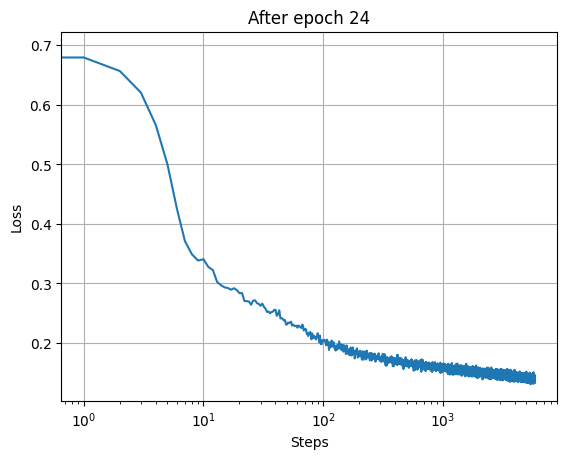

100%|██████████| 32/32 [01:16<00:00,  2.39s/it, Loss=0.13358472287654877]


In [708]:
model.train() # set in train mode. Useful for training specific behaviors.

for i in (pbar := trange(epochs)):
    for left, right, label in loader_train:
        loss = model.loss(left, right, label)

        # Empty previous gradient values of tracked parameters by setting them to zero
        optim.zero_grad()

        # This will update gradient values for every tracked parameters
        loss.backward()

        # Update the parameters values from the computed gradient using the selected optimization algorithm (here, Adam)
        optim.step()

        losses.append(loss.item())
        pbar.set_postfix({"Loss":str(loss.item())})

    if i%show_every == 0:
        plt.plot(losses)
        plt.title(f"After epoch {i}")
        plt.ylabel("Loss")
        plt.xlabel("Steps")
        plt.xscale("log")
        plt.grid()
        plt.show()

# Evaluate the model

Now that our network is trained, we can visualize its prediction on the test set and evaluate its performances.

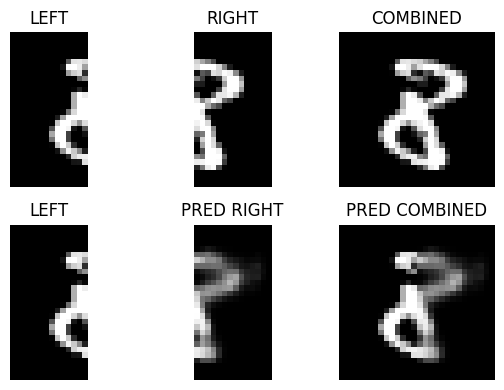

LABEL: 8


In [713]:
left, right, label = test_set[torch.randint(0, len(test_set), (1,))[0]]
label = torch.as_tensor(label)

full_target = recompose_image(left, right)

model.eval() # disable training specific behaviors

# Do not need to keep track of the gradients while testing
with torch.no_grad():
    pred_right = model(left.unsqueeze(0), label.unsqueeze(0)).squeeze()

f, a = plt.subplots(2, 3, figsize=(6, 4))
a[0, 0].imshow(left, cmap="grey")
a[0, 0].set_title("LEFT")

a[0, 1].imshow(right, cmap="grey")
a[0, 1].set_title("RIGHT")

a[1, 0].imshow(left, cmap="grey")
a[1, 0].set_title("LEFT")

a[1, 1].imshow(pred_right, cmap="grey")
a[1, 1].set_title("PRED RIGHT")

a[0, 2].imshow(recompose_image(left, right), cmap="grey")
a[0, 2].set_title("COMBINED")

a[1, 2].imshow(recompose_image(left, pred_right), cmap="grey")
a[1, 2].set_title("PRED COMBINED")

for l in a:
    for c in l:
        c.axis("off")

plt.tight_layout()
plt.show()

print("LABEL:", label.item())

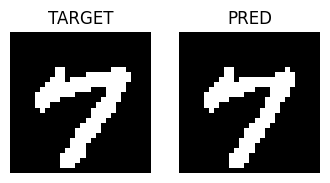

ACCURACY: tensor(0.9515)


In [710]:
# You can compute the accuracy of your classifier. 
# As you return the probability of being white, you can set a threshold on this value to assign a class to a pixel.
# A threshold of 0.5 is equivalent to an argmax sampling. 
# If p > 0.5 -> white
# If p < 0.5 -> 1 - p > 0.5 -> black

# ARGMAX COMPARISON
threshold = .5

left, right, label = test_set[torch.randint(0, len(test_set), (1,))[0]]
label = torch.as_tensor(label)

with torch.no_grad():
    pred_right = model(left.unsqueeze(0), label.unsqueeze(0)).squeeze()

target = recompose_image(left, right) > threshold
pred = recompose_image(left, pred_right) > threshold

f, a = plt.subplots(1, 2, figsize=(4, 2))
a[0].imshow(target, cmap="grey")
a[0].set_title("TARGET")
a[0].axis("off")

a[1].imshow(pred, cmap="grey")
a[1].set_title("PRED")
a[1].axis("off")

plt.show()

# And you can derive the accuracy for this prediction
print("ACCURACY:", (pred[:,14:] == target[:,14:]).sum()/(14*28)) # Derived only on guessed half

100%|██████████| 235/235 [00:04<00:00, 58.49it/s]


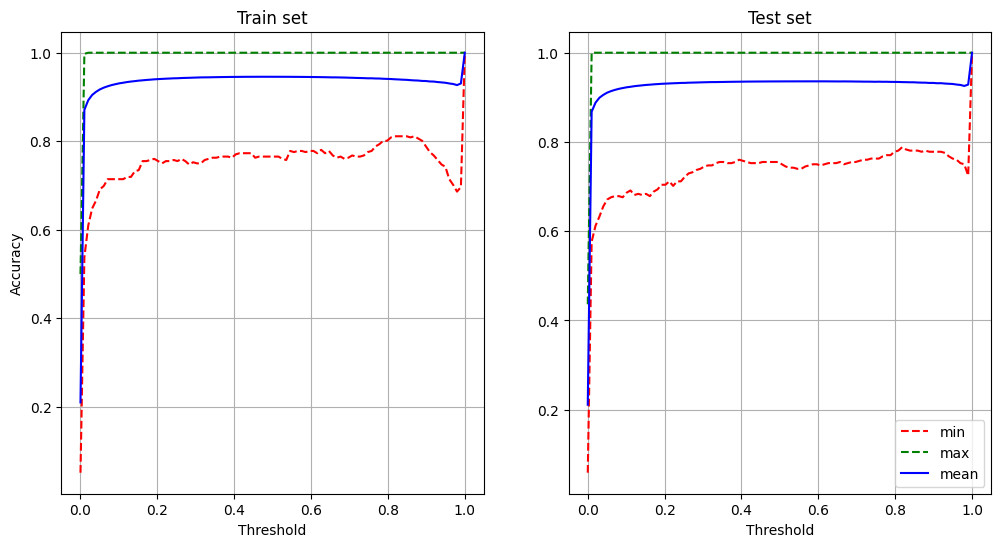

In [711]:
# A good habit is to evaluate the global performances of your model
# Here below, we derive the accuracy over the whole test set for several thresholds

thresholds = torch.linspace(0, 1, 100)
results_train = []
results_test = []

with torch.no_grad():
    for left, right, label in tqdm(loader_train):
        with torch.no_grad():
            pred_right = model(left, label).squeeze()

        res = []
        for th in thresholds:
            pr = pred_right > th
            r = right > th
            acc = pr == r

            res.append(acc.sum((1,2))/(14*28))

        results_train.append(torch.stack(res, dim=-1))
        
    results_train = torch.cat(results_train)

    for left, right, label in tqdm(loader_test):
        with torch.no_grad():
            pred_right = model(left, label).squeeze()

        res = []
        for th in thresholds:
            pr = pred_right > th
            r = right > th
            acc = pr == r

            res.append(acc.sum((1,2))/(14*28))

        results_test.append(torch.stack(res, dim=-1))
        
    results_test = torch.cat(results_test)

        
f, a = plt.subplots(1, 2, figsize=(12, 6))
a[0].plot(thresholds, results_train.min(0)[0], "r--", label="min")
a[0].plot(thresholds, results_train.max(0)[0], "g--", label="max")
a[0].plot(thresholds, results_train.mean(0), "b", label="mean")
a[0].set_ylabel("Accuracy")
a[0].set_xlabel("Threshold")
a[0].set_title("Train set")
a[0].grid()

a[1].plot(thresholds, results_test.min(0)[0], "r--", label="min")
a[1].plot(thresholds, results_test.max(0)[0], "g--", label="max")
a[1].plot(thresholds, results_test.mean(0), "b", label="mean")
a[1].set_xlabel("Threshold")
a[1].set_title("Test set")
a[1].grid()

plt.legend()
plt.show()

# Save and load module

In [712]:
save_file = "my_model.pt"
# Save a pytorch module
torch.save(model.state_dict(), save_file)

# Reload the model. To do so, we first create a new similar model and then load the saved weights
new_model = MLP(H, W, features, hiddens)

# Let's look at the lookup table for labels embedding to see that the weights changes after loading. We check the first embedding.
print("NEW RANDOM MODEL:\n", new_model.embed_label.weight.data[0])

new_model.load_state_dict(torch.load(save_file, weights_only=True))

print("LOADED MODEL:\n", new_model.embed_label.weight.data[0])

NEW RANDOM MODEL:
 tensor([-0.4898, -0.9084,  0.8521,  0.2713, -1.9216, -0.3120,  0.7471, -0.1053,
        -0.5952,  0.2202,  0.2674,  1.0853,  0.7142, -0.8050,  0.1522,  0.9507,
        -1.2280,  0.9453, -0.3521, -0.0833, -0.8845,  0.5522, -0.4308,  0.8243,
        -0.7509, -1.0473,  1.4036, -1.3706, -0.1297,  0.7062,  0.5740, -1.4328])
LOADED MODEL:
 tensor([-0.8729,  0.9246,  0.3099, -0.7699, -0.8447, -0.3356, -0.0593, -0.2018,
        -0.1449, -2.4211, -0.7060, -0.2875,  0.7798,  1.3184, -0.2688, -0.2417,
        -0.2460, -0.1302, -0.0659, -1.0061, -1.1163, -0.1247,  1.4658, -0.6383,
         0.8417, -0.5291,  0.4884,  1.6054,  0.2681, -0.7223,  0.4569,  0.5166])
